# 1. Cargando base de datos

In [137]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [138]:
import matplotlib.pyplot as plt

In [139]:
import numpy as np

In [140]:
import importlib

In [141]:
import sys

In [142]:
sys.path.insert(0, '..')

In [143]:
sys.path.insert(0, '../..')

In [144]:
# Read the database from the .csv file into a pandas dataframe
df = pd.read_csv('../../databases/insurance.csv')

# 2. Preprocesamiento de los datos

In [145]:
from sklearn import preprocessing

In [146]:
from src import helper
importlib.reload(helper);

## 2.1. Codificación de variables no numéricas o categóricas

In [147]:
# Create a label encoder for the sex variable or feature and create a new column in the dataframe 
# with the encoded version of the gender
sex_encoder = preprocessing.LabelEncoder()
sex_encoder.fit(df['sex'])
df['sex-encoded'] = sex_encoder.transform(df['sex'])

In [148]:
# Create a label encoder for the smoker variable or feature and create a new column in the dataframe
# with the encoded version of the smoker
smoker_encoder = preprocessing.LabelEncoder()
smoker_encoder.fit(df['smoker'])
df['smoker-encoded'] = smoker_encoder.transform(df['smoker'])

In [149]:
# Create a label encoder for the region variable or feature and create a new column in the dataframe
# with the encoded version of the region
region_encoder = preprocessing.LabelEncoder()
region_encoder.fit(df['region'])
df['region-encoded'] = region_encoder.transform(df['region'])

In [150]:
df.head()

,age,sex,bmi,children,smoker,region,charges,sex-encoded,smoker-encoded,region-encoded
0,19,female,27.900,0,yes,southwest,16884.92400,0,1,3
1,18,male,33.770,1,no,southeast,1725.55230,1,0,2
2,28,male,33.000,3,no,southeast,4449.46200,1,0,2
3,33,male,22.705,0,no,northwest,21984.47061,1,0,1
4,32,male,28.880,0,no,northwest,3866.85520,1,0,1


## 2.2. Eliminando outliers

In [151]:
# Remove outliers by setting NaN on those rows at the column of BMI
helper.remove_outliers(df, 'bmi')

# Remove NaN values from the dataframe
df = df.dropna()

## 2.3. Filtrado de variables

In [152]:
# Filtering or removing of non desired variables
df_x = df[['age', 'bmi', 'smoker-encoded', 'children', 'sex-encoded', 'region-encoded']]
df_y = df['charges']

# 3. Separación del conjunto de entrenamiento y evaluación

In [153]:
from sklearn import model_selection

## 3.1. Separación de los conjuntos

In [162]:
# Split the dataset into train_valid and test
x_train_valid, x_test, y_train_valid, y_test = model_selection.train_test_split(df_x, df_y, test_size=0.2, random_state=15, shuffle=True)

## 3.2. Normalización de variables

In [163]:
# Select the variables where the z-score will be applied
scalable_variables = ['bmi', 'age']

if scalable_variables:
    # Create an instance of the StandardScaler for each variable
    scaler = preprocessing.StandardScaler()

    # Fit the distribution
    scaler.fit(x_train_valid.loc[:, scalable_variables])

    # Transform and normalize all variables
    x_test.loc[:, scalable_variables] = scaler.transform(x_test.loc[:, scalable_variables])

## 3.3. Formato de conjuntos

In [164]:
x_test = [x_test[['age', 'bmi', 'smoker-encoded', 'children', 'sex-encoded']], x_test['region-encoded']]

# 4. Multilayer Perceptron y K-Folding

In [165]:
from src.ej2 import mlp_helper
importlib.reload(mlp_helper);

In [166]:
# Amount of folds
number_folds = 8

# Create an instance of a K-Folding handler
kf = model_selection.KFold(n_splits=number_folds, random_state=12, shuffle=True)

# Generate arrays to contain train, valid and test metrics
train_metrics = np.zeros(number_folds)
valid_metrics = np.zeros(number_folds)
test_metrics = np.zeros(number_folds)

# Iterate through each fold
for i, (train, valid) in enumerate(kf.split(x_train_valid, y_train_valid)):
    
    # Get the train set
    x_train = x_train_valid.iloc[train].copy()
    y_train = y_train_valid.iloc[train].copy()
    
    # Get the valid set
    x_valid = x_train_valid.iloc[valid].copy()
    y_valid = y_train_valid.iloc[valid].copy()
    
    # Select the variables where the z-score will be applied
    scalable_variables = ['bmi', 'age']
    if scalable_variables:
        # Create an instance of the StandardScaler for each variable
        scaler = preprocessing.StandardScaler()

        # Fit the distribution
        scaler.fit(x_train.loc[:, scalable_variables])

        # Transform and normalize all variables
        x_train.loc[:, scalable_variables] = scaler.transform(x_train.loc[:, scalable_variables])
        x_valid.loc[:, scalable_variables] = scaler.transform(x_valid.loc[:, scalable_variables])
        
    x_train = [x_train[['age', 'bmi', 'smoker-encoded', 'children', 'sex-encoded']], x_train['region-encoded']]
    x_valid = [x_valid[['age', 'bmi', 'smoker-encoded', 'children', 'sex-encoded']], x_valid['region-encoded']]
    
    # Run model
    mae_train, mae_valid, mae_test = mlp_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                          hidden_layers=1,
                                                          units_per_layer=1500,
                                                          hidden_layer_activation='tanh',
                                                          epochs=500,
                                                          batch_size=64,
                                                          learning_rate=0.5, 
                                                          decay_rate=0.01,
                                                          optimizer='adam',
                                                          beta_1=0.99,
                                                          beta_2=0.999,
                                                          tag='k-fold',
                                                          tensorboard_on=False,
                                                          summary_on=False,
                                                          verbose=2
                                                         )
    
    # Save metrics
    train_metrics[i] = mae_train
    valid_metrics[i] = mae_valid
    test_metrics[i] = mae_test

# Inform results!
print(f'[MAE] Train: {round(train_metrics.mean(), 2)} Valid: {round(valid_metrics.mean(), 2)} Test: {round(test_metrics.mean(), 2)}')

[MAE] Train: 1381.43875 Valid: 1568.1712499999999 Test: 1736.705


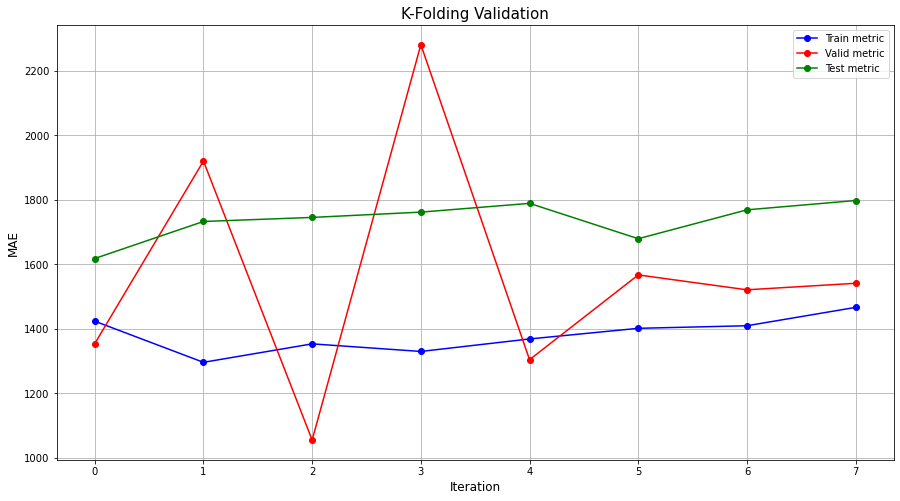

In [180]:
# Create and plot the train, valid and test metrics throughout the 
# iteration of the k-folding validation process
plt.subplots(1, 1, figsize=(15, 8))
plt.plot(train_metrics, label='Train metric', color='blue', marker='o')
plt.plot(valid_metrics, label='Valid metric', color='red', marker='o')
plt.plot(test_metrics, label='Test metric', color='green', marker='o')
plt.title('K-Folding Validation', fontsize=15)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.legend()
plt.grid()
plt.show()